# Proyecto BBVA y Santander

## Importar librerías

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## DESCARGA DE DATOS

In [16]:
tickers = ["BBVA.MC", "SAN.MC"]  # BBVA y Banco Santander
start_date = "2010-01-01"
end_date = "2025-01-01"

data = {}
for t in tickers:
    df = yf.download(t, start=start_date, end=end_date)
    data[t] = df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15880\876204869.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15880\876204869.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 1. leer normal (una sola cabecera)
df = pd.read_csv("csv\ibex35_data.csv")

# ahora df.head() será algo como:
#    Price   Close    High     Low    Open  Volume
# 0  Ticker  ^IBEX    ^IBEX   ... 
# 1  Date    NaN      NaN     ...
# 2  2000-01-03 11609 ... 

# 2. eliminar las filas “raras” (las 2 primeras)
df = df[~df["Price"].isin(["Ticker", "Date"])].copy()

# 3. renombrar la primera columna porque en realidad es la fecha
df = df.rename(columns={"Price": "Date"})

# 4. convertir la fecha
df["Date"] = pd.to_datetime(df["Date"])

# 5. convertir el resto a numérico
for col in ["Close", "High", "Low", "Open", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Para ser coherentes con lo anterior, creamos una columna PRICE fija:
df["Price"] = pd.to_numeric(df["Close"], errors="coerce")

# ordenar por fecha
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print(df.dtypes)



        Date         Close          High           Low          Open  Volume  \
0 2000-01-03  11609.988281  11881.787812  11574.388708  11641.388640       0   
1 2000-01-04  11206.587891  11529.987943  11159.788135  11529.987943       0   
2 2000-01-05  10863.088867  11068.088664  10824.889686  11068.088664       0   
3 2000-01-07  11102.388672  11137.888634  10882.688708  10882.688708       0   
4 2000-01-10  11173.288086  11364.287886  11120.587946  11120.587946       0   

          Price  
0  11609.988281  
1  11206.587891  
2  10863.088867  
3  11102.388672  
4  11173.288086  
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Price            float64
dtype: object


## PREPROCESAMIENTO

In [23]:
def preparar_datos_desde_df(df, col_target="Price", window_size=30):
    df = df.sort_values("Date").reset_index(drop=True)

    if col_target not in df.columns:
        raise ValueError(f"No encuentro la columna {col_target}. Tengo: {df.columns.tolist()}")

    valores = df[[col_target]].values.astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    valores_scaled = scaler.fit_transform(valores)

    X, y = [], []
    for i in range(window_size, len(valores_scaled)):
        X.append(valores_scaled[i-window_size:i, 0])
        y.append(valores_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler, df

window_size = 30
X_ibex, y_ibex, scaler_ibex, ibex_df = preparar_datos_desde_df(df, col_target="Price", window_size=window_size)

print("X_ibex:", X_ibex.shape)
print("y_ibex:", y_ibex.shape)



X_ibex: (6072, 30, 1)
y_ibex: (6072,)


## Train y test temporal

In [24]:
# 80% train, 20% test (temporal, sin shuffle)
train_size = int(len(X_ibex) * 0.8)
X_train, X_test = X_ibex[:train_size], X_ibex[train_size:]
y_train, y_test = y_ibex[:train_size], y_ibex[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (4857, 30, 1) (4857,)
Test : (1215, 30, 1) (1215,)


## Modelos

In [25]:
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


## Entrenamiento

In [40]:
EPOCHS = 1000
BATCH = 32

# Callbacks comunes
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=80,             # se detiene si 80 epochs sin mejorar
    restore_best_weights=True
)

def entrenar_modelo(nombre, build_fn, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo (RNN, LSTM o GRU) con EarlyStopping y ModelCheckpoint
    """
    print(f"\nEntrenando modelo {nombre}...\n")
    model = build_fn()
    checkpoint = ModelCheckpoint(
        f"mejor_{nombre.lower()}_ibex.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    return model, history

# ==============================
# ENTRENAR LOS TRES
# ==============================

rnn_model,  hist_rnn  = entrenar_modelo("RNN",  build_rnn,  X_train, y_train, X_test, y_test)
lstm_model, hist_lstm = entrenar_modelo("LSTM", build_lstm, X_train, y_train, X_test, y_test)
gru_model,  hist_gru  = entrenar_modelo("GRU",  build_gru,  X_train, y_train, X_test, y_test)



Entrenando modelo RNN...

Epoch 1/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089
Epoch 1: val_loss improved from None to 0.00064, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - val_loss: 6.3969e-04
Epoch 2/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6431e-04
Epoch 2: val_loss improved from 0.00064 to 0.00040, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9584e-04 - val_loss: 3.9964e-04
Epoch 3/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0832e-04
Epoch 3: val_loss improved from 0.00040 to 0.00032, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7370e-04 - val_loss: 3.2499e-04
Epoch 4/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8505e-04
Epoch 4: val_loss improved from 0.00032 to 0.00032, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6446e-04 - val_loss: 3.2098e-04
Epoch 5/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0197e-04
Epoch 5: val_loss improved from 0.00032 to 0.00027, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8212e-04 - val_loss: 2.6638e-04
Epoch 6/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5680e-04
Epoch 6: val_loss improved from 0.00027 to 0.00025, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3496e-04 - val_loss: 2.4524e-04
Epoch 7/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0704e-04
Epoch 7: val_loss improved from 0.00025 to 0.00021, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1312e-04 - val_loss: 2.1227e-04
Epoch 8/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9961e-04
Epoch 8: val_loss improved from 0.00021 to 0.00015, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7765e-04 - val_loss: 1.5153e-04
Epoch 9/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6745e-04
Epoch 9: val_loss did not improve from 0.00015
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5999e-04 - val_loss: 1.5212e-04
Epoch 10/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4873e-04
Epoch 10: val_loss improved from 0.00015 to 0.00015, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4660e-04 - val_loss: 1.4984e-04
Epoch 11/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4811e-04
Epoch 11: val_loss did not improve from 0.00015
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5118e-04 - val_loss: 1.7670e-04
Epoch 12/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0515e-04
Epoch 12: val_loss did not improve from 0.00015
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5107e-04 - val_loss: 1.7141e-04
Epoch 13/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3203e-04
Epoch 13: val_loss improved from 0.00015 to 0.00012, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1881e-04 - val_loss: 1.2337e-04
Epoch 14/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1181e-04
Epoch 14: val_loss improved from 0.00012 to 0.00012, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0328e-04 - val_loss: 1.1555e-04
Epoch 15/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4048e-04
Epoch 15: val_loss improved from 0.00012 to 0.00011, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2049e-04 - val_loss: 1.1027e-04
Epoch 16/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9399e-04
Epoch 16: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9382e-04 - val_loss: 1.1111e-04
Epoch 17/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9839e-04
Epoch 17: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9527e-04 - val_loss: 1.1919e-04
Epoch 18/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9516e-04
Epoch 18: val_loss improved from 0.00011 to 0.00011, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8967e-04 - val_loss: 1.0634e-04
Epoch 19/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8897e-04
Epoch 19: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8989e-04 - val_loss: 1.0836e-04
Epoch 20/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7946e-04
Epoch 20: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9511e-04 - val_loss: 1.2001e-04
Epoch 21/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8186e-04
Epoch 21: val_loss improved from 0.00011 to 0.00011, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8634e-04 - val_loss: 1.0538e-04
Epoch 22/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9746e-04
Epoch 22: val_loss improved from 0.00011 to 0.00010, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9425e-04 - val_loss: 1.0294e-04
Epoch 23/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8235e-04
Epoch 23: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8794e-04 - val_loss: 1.1268e-04
Epoch 24/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0359e-04
Epoch 24: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9152e-04 - val_loss: 1.1468e-04
Epoch 25/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9540e-04
Epoch 25: val_loss improved from 0.00010 to 0.00010, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0300e-04 - val_loss: 1.0173e-04
Epoch 26/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7718e-04
Epoch 26: val_loss improved from 0.00010 to 0.00010, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8505e-04 - val_loss: 1.0140e-04
Epoch 27/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7124e-04
Epoch 27: val_loss improved from 0.00010 to 0.00010, saving model to mejor_rnn_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8479e-04 - val_loss: 1.0123e-04
Epoch 28/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8105e-04
Epoch 28: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9229e-04 - val_loss: 1.3039e-04
Epoch 29/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9282e-04
Epoch 29: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8861e-04 - val_loss: 1.2621e-04
Epoch 30/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8601e-04
Epoch 30: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8578e-04 - val_loss: 1.0324e-04
Epoch 31/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9187e-04
Epoch 31: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9484e-04 - val_loss: 1.1330e-04
Epoch 32/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8183e-04
Epoch 32: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8582e-04 - val_loss: 1.0114e-04
Epoch 34/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7723e-04
Epoch 34: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8681e-04 - val_loss: 1.0628e-04
Epoch 35/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0462e-04
Epoch 35: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8746e-04 - val_loss: 1.2795e-04
Epoch 36/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6961e-04
Epoch 36: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7889e-04 - val_loss: 1.1389e-04
Epoch 37/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8378e-04
Epoch 37: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8344e-04 - val_loss: 1.0225e-04
Epoch 38/1000
130/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7168e-04
Epoch 38: val_loss impr

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8528e-04 - val_loss: 1.0102e-04
Epoch 39/1000
128/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7196e-04
Epoch 39: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7541e-04 - val_loss: 1.0371e-04
Epoch 40/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7599e-04
Epoch 40: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8636e-04 - val_loss: 1.2016e-04
Epoch 41/1000
134/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9167e-04
Epoch 41: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7593e-04 - val_loss: 1.0466e-04
Epoch 42/1000
131/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8206e-04
Epoch 42: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8334e-04 - val_loss: 1.1907e-04
Epoch 43/1000
129/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8495e-04
Epoch 43: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8740e-04 - val_loss: 1.0080e-04
Epoch 65/1000
136/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7971e-04
Epoch 65: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8661e-04 - val_loss: 1.0621e-04
Epoch 66/1000
128/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8952e-04
Epoch 66: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8149e-04 - val_loss: 1.0511e-04
Epoch 67/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6578e-04
Epoch 67: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7818e-04 - val_loss: 1.0264e-04
Epoch 68/1000
131/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7581e-04
Epoch 68: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8450e-04 - val_loss: 1.1264e-04
Epoch 69/1000
131/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8532e-04
Epoch 69: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7760e-04 - val_loss: 9.9756e-05
Epoch 75/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7495e-04
Epoch 75: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8995e-04 - val_loss: 1.0364e-04
Epoch 76/1000
127/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8578e-04
Epoch 76: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8948e-04 - val_loss: 1.0153e-04
Epoch 77/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8340e-04
Epoch 77: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8199e-04 - val_loss: 1.3863e-04
Epoch 78/1000
128/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9191e-04
Epoch 78: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8294e-04 - val_loss: 1.0537e-04
Epoch 79/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7376e-04
Epoch 79: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7861e-04 - val_loss: 9.9269e-05
Epoch 110/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8362e-04
Epoch 110: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8594e-04 - val_loss: 1.0129e-04
Epoch 111/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7804e-04
Epoch 111: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8764e-04 - val_loss: 1.0554e-04
Epoch 112/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8590e-04
Epoch 112: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8019e-04 - val_loss: 1.0148e-04
Epoch 113/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7137e-04
Epoch 113: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8290e-04 - val_loss: 1.0070e-04
Epoch 114/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7568e-04
Epoch 114: val

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8213e-04 - val_loss: 9.9239e-05
Epoch 124/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6681e-04
Epoch 124: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8062e-04 - val_loss: 1.0022e-04
Epoch 125/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8347e-04
Epoch 125: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7990e-04 - val_loss: 1.0206e-04
Epoch 126/1000
133/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8159e-04
Epoch 126: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8275e-04 - val_loss: 1.0218e-04
Epoch 127/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7111e-04
Epoch 127: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8210e-04 - val_loss: 1.0167e-04
Epoch 128/1000
138/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7733e-04
Epoch 128: val

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7885e-04 - val_loss: 9.9201e-05
Epoch 134/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9766e-04
Epoch 134: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8463e-04 - val_loss: 1.1555e-04
Epoch 135/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7666e-04
Epoch 135: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8062e-04 - val_loss: 1.1431e-04
Epoch 136/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9028e-04
Epoch 136: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8266e-04 - val_loss: 1.1764e-04
Epoch 137/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7967e-04
Epoch 137: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7930e-04 - val_loss: 1.0315e-04
Epoch 138/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8254e-04
Epoch 138: val

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7705e-04 - val_loss: 9.8916e-05
Epoch 144/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8399e-04
Epoch 144: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8002e-04 - val_loss: 1.3510e-04
Epoch 145/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9365e-04
Epoch 145: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8273e-04 - val_loss: 1.0256e-04
Epoch 146/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8406e-04
Epoch 146: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7932e-04 - val_loss: 1.1136e-04
Epoch 147/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9426e-04
Epoch 147: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7933e-04 - val_loss: 1.0575e-04
Epoch 148/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7885e-04
Epoch 148: val

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048 - val_loss: 5.6245e-04
Epoch 2/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5578e-04
Epoch 2: val_loss improved from 0.00056 to 0.00050, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4813e-04 - val_loss: 4.9515e-04
Epoch 3/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0381e-04
Epoch 3: val_loss improved from 0.00050 to 0.00045, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7744e-04 - val_loss: 4.4722e-04
Epoch 4/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3511e-04
Epoch 4: val_loss improved from 0.00045 to 0.00039, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2406e-04 - val_loss: 3.9126e-04
Epoch 5/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9432e-04
Epoch 5: val_loss improved from 0.00039 to 0.00036, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8314e-04 - val_loss: 3.5845e-04
Epoch 6/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7153e-04
Epoch 6: val_loss improved from 0.00036 to 0.00032, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5971e-04 - val_loss: 3.1798e-04
Epoch 7/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4535e-04
Epoch 7: val_loss improved from 0.00032 to 0.00029, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1933e-04 - val_loss: 2.8906e-04
Epoch 8/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9444e-04
Epoch 8: val_loss improved from 0.00029 to 0.00027, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1689e-04 - val_loss: 2.7228e-04
Epoch 9/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9056e-04
Epoch 9: val_loss did not improve from 0.00027
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8079e-04 - val_loss: 3.0983e-04
Epoch 10/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6248e-04
Epoch 10: val_loss improved from 0.00027 to 0.00023, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5883e-04 - val_loss: 2.3138e-04
Epoch 11/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4163e-04
Epoch 11: val_loss improved from 0.00023 to 0.00023, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4004e-04 - val_loss: 2.2717e-04
Epoch 12/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2399e-04
Epoch 12: val_loss improved from 0.00023 to 0.00021, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1201e-04 - val_loss: 2.0636e-04
Epoch 13/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8385e-04
Epoch 13: val_loss improved from 0.00021 to 0.00020, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0007e-04 - val_loss: 1.9944e-04
Epoch 14/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8273e-04
Epoch 14: val_loss improved from 0.00020 to 0.00018, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9047e-04 - val_loss: 1.8455e-04
Epoch 15/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7359e-04
Epoch 15: val_loss improved from 0.00018 to 0.00017, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6789e-04 - val_loss: 1.6957e-04
Epoch 16/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6769e-04
Epoch 16: val_loss did not improve from 0.00017
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6611e-04 - val_loss: 1.8722e-04
Epoch 17/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5497e-04
Epoch 17: val_loss improved from 0.00017 to 0.00015, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5536e-04 - val_loss: 1.5300e-04
Epoch 18/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3422e-04
Epoch 18: val_loss did not improve from 0.00015
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3540e-04 - val_loss: 1.6044e-04
Epoch 19/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5572e-04
Epoch 19: val_loss improved from 0.00015 to 0.00014, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4192e-04 - val_loss: 1.3970e-04
Epoch 20/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1458e-04
Epoch 20: val_loss did not improve from 0.00014
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1761e-04 - val_loss: 1.4031e-04
Epoch 21/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1700e-04
Epoch 21: val_loss did not improve from 0.00014
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1560e-04 - val_loss: 1.7172e-04
Epoch 22/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4333e-04
Epoch 22: val_loss improved from 0.00014 to 0.00014, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2404e-04 - val_loss: 1.3967e-04
Epoch 23/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1742e-04
Epoch 23: val_loss improved from 0.00014 to 0.00012, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1709e-04 - val_loss: 1.2313e-04
Epoch 24/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9229e-04
Epoch 24: val_loss improved from 0.00012 to 0.00012, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9792e-04 - val_loss: 1.1730e-04
Epoch 25/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9523e-04
Epoch 25: val_loss improved from 0.00012 to 0.00011, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9193e-04 - val_loss: 1.1451e-04
Epoch 26/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8965e-04
Epoch 26: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0191e-04 - val_loss: 1.6259e-04
Epoch 27/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9492e-04
Epoch 27: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9592e-04 - val_loss: 1.1925e-04
Epoch 28/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9594e-04
Epoch 28: val_loss improved from 0.00011 to 0.00011, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9271e-04 - val_loss: 1.0671e-04
Epoch 29/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8541e-04
Epoch 29: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8420e-04 - val_loss: 1.0697e-04
Epoch 30/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9162e-04
Epoch 30: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8547e-04 - val_loss: 1.2293e-04
Epoch 31/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8141e-04
Epoch 31: val_loss improved from 0.00011 to 0.00010, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8288e-04 - val_loss: 1.0395e-04
Epoch 32/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8545e-04
Epoch 32: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8274e-04 - val_loss: 1.0934e-04
Epoch 33/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7292e-04
Epoch 33: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8018e-04 - val_loss: 1.1098e-04
Epoch 34/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9059e-04
Epoch 34: val_loss improved from 0.00010 to 0.00010, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8795e-04 - val_loss: 1.0251e-04
Epoch 35/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7687e-04
Epoch 35: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8060e-04 - val_loss: 1.0259e-04
Epoch 36/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7502e-04
Epoch 36: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7838e-04 - val_loss: 1.0500e-04
Epoch 37/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8390e-04
Epoch 37: val_loss improved from 0.00010 to 0.00010, saving model to mejor_lstm_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8519e-04 - val_loss: 1.0096e-04
Epoch 38/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7574e-04
Epoch 38: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8216e-04 - val_loss: 1.0147e-04
Epoch 39/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7649e-04
Epoch 39: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7859e-04 - val_loss: 1.0245e-04
Epoch 40/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9250e-04
Epoch 40: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8557e-04 - val_loss: 1.0713e-04
Epoch 41/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8251e-04
Epoch 41: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8328e-04 - val_loss: 1.1357e-04
Epoch 42/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8946e-04
Epoch 42: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7637e-04 - val_loss: 1.0057e-04
Epoch 44/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8584e-04
Epoch 44: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8144e-04 - val_loss: 1.0543e-04
Epoch 45/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7687e-04
Epoch 45: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7728e-04 - val_loss: 1.1035e-04
Epoch 46/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9326e-04
Epoch 46: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8145e-04 - val_loss: 1.0540e-04
Epoch 47/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7586e-04
Epoch 47: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7685e-04 - val_loss: 1.0396e-04
Epoch 48/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6710e-04
Epoch 48: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7794e-04 - val_loss: 9.9663e-05
Epoch 53/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7197e-04
Epoch 53: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8018e-04 - val_loss: 1.0812e-04
Epoch 54/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7932e-04
Epoch 54: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7741e-04 - val_loss: 9.9983e-05
Epoch 55/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7389e-04
Epoch 55: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8211e-04 - val_loss: 1.1033e-04
Epoch 56/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7540e-04
Epoch 56: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7353e-04 - val_loss: 1.0619e-04
Epoch 57/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7740e-04
Epoch 57: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8183e-04 - val_loss: 9.9175e-05
Epoch 63/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6258e-04
Epoch 63: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7745e-04 - val_loss: 1.0952e-04
Epoch 64/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7463e-04
Epoch 64: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7545e-04 - val_loss: 1.1348e-04
Epoch 65/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7708e-04
Epoch 65: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7512e-04 - val_loss: 9.9517e-05
Epoch 66/1000
141/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7234e-04
Epoch 66: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7775e-04 - val_loss: 1.0599e-04
Epoch 67/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9285e-04
Epoch 67: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7922e-04 - val_loss: 9.9088e-05
Epoch 74/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8060e-04
Epoch 74: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7320e-04 - val_loss: 1.0020e-04
Epoch 75/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6132e-04
Epoch 75: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7687e-04 - val_loss: 1.7506e-04
Epoch 76/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6463e-04
Epoch 76: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7969e-04 - val_loss: 1.1054e-04
Epoch 77/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8065e-04
Epoch 77: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7536e-04 - val_loss: 9.9580e-05
Epoch 78/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6575e-04
Epoch 78: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0079 - val_loss: 2.4101e-04
Epoch 2/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2014e-04
Epoch 2: val_loss improved from 0.00024 to 0.00020, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1629e-04 - val_loss: 2.0456e-04
Epoch 3/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9811e-04
Epoch 3: val_loss improved from 0.00020 to 0.00018, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8278e-04 - val_loss: 1.8316e-04
Epoch 4/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6410e-04
Epoch 4: val_loss improved from 0.00018 to 0.00017, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6228e-04 - val_loss: 1.6798e-04
Epoch 5/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5510e-04
Epoch 5: val_loss did not improve from 0.00017
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4607e-04 - val_loss: 1.7476e-04
Epoch 6/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4127e-04
Epoch 6: val_loss improved from 0.00017 to 0.00015, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3650e-04 - val_loss: 1.4662e-04
Epoch 7/1000
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2758e-04
Epoch 7: val_loss did not improve from 0.00015
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3485e-04 - val_loss: 1.5675e-04
Epoch 8/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2773e-04
Epoch 8: val_loss improved from 0.00015 to 0.00014, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2570e-04 - val_loss: 1.4381e-04
Epoch 9/1000
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0896e-04
Epoch 9: val_loss did not improve from 0.00014
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2405e-04 - val_loss: 1.5345e-04
Epoch 10/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2930e-04
Epoch 10: val_loss improved from 0.00014 to 0.00013, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2047e-04 - val_loss: 1.2651e-04
Epoch 11/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0274e-04
Epoch 11: val_loss improved from 0.00013 to 0.00012, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1242e-04 - val_loss: 1.2475e-04
Epoch 12/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0594e-04
Epoch 12: val_loss improved from 0.00012 to 0.00012, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1006e-04 - val_loss: 1.2040e-04
Epoch 13/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9385e-04
Epoch 13: val_loss did not improve from 0.00012
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0040e-04 - val_loss: 1.2221e-04
Epoch 14/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9767e-04
Epoch 14: val_loss improved from 0.00012 to 0.00012, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9918e-04 - val_loss: 1.1617e-04
Epoch 15/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9743e-04
Epoch 15: val_loss did not improve from 0.00012
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0864e-04 - val_loss: 1.2271e-04
Epoch 16/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9113e-04
Epoch 16: val_loss did not improve from 0.00012
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9839e-04 - val_loss: 1.3166e-04
Epoch 17/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1057e-04
Epoch 17: val_loss improved from 0.00012 to 0.00011, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0588e-04 - val_loss: 1.1122e-04
Epoch 18/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2637e-04
Epoch 18: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1092e-04 - val_loss: 1.1507e-04
Epoch 19/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9915e-04
Epoch 19: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9452e-04 - val_loss: 1.2048e-04
Epoch 20/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8696e-04
Epoch 20: val_loss improved from 0.00011 to 0.00011, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8721e-04 - val_loss: 1.0820e-04
Epoch 21/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7715e-04
Epoch 21: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9127e-04 - val_loss: 1.2069e-04
Epoch 22/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8615e-04
Epoch 22: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9102e-04 - val_loss: 1.3516e-04
Epoch 23/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0100e-04
Epoch 23: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8661e-04 - val_loss: 1.0943e-04
Epoch 24/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8320e-04
Epoch 24: val_loss did not improve from 0.00011
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8642e-04 - val_loss: 1.1616e-04
Epoch 25/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8494e-04
Epoch 25: val_loss impr

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8768e-04 - val_loss: 1.0268e-04
Epoch 26/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8315e-04
Epoch 26: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8266e-04 - val_loss: 1.1565e-04
Epoch 27/1000
148/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9134e-04
Epoch 27: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8734e-04 - val_loss: 1.0813e-04
Epoch 28/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8056e-04
Epoch 28: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8444e-04 - val_loss: 1.1797e-04
Epoch 29/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8851e-04
Epoch 29: val_loss improved from 0.00010 to 0.00010, saving model to mejor_gru_ibex.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9788e-04 - val_loss: 1.0129e-04
Epoch 30/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9456e-04
Epoch 30: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8394e-04 - val_loss: 1.0180e-04
Epoch 31/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7806e-04
Epoch 31: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8537e-04 - val_loss: 1.1116e-04
Epoch 32/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9437e-04
Epoch 32: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9297e-04 - val_loss: 1.2889e-04
Epoch 33/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0238e-04
Epoch 33: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9530e-04 - val_loss: 1.4393e-04
Epoch 34/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8761e-04
Epoch 34: val_loss impr

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8604e-04 - val_loss: 1.0019e-04
Epoch 35/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8512e-04
Epoch 35: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8023e-04 - val_loss: 1.0182e-04
Epoch 36/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7615e-04
Epoch 36: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8187e-04 - val_loss: 1.1583e-04
Epoch 37/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7108e-04
Epoch 37: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7967e-04 - val_loss: 1.1902e-04
Epoch 38/1000
145/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7699e-04
Epoch 38: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7846e-04 - val_loss: 1.0153e-04
Epoch 39/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8215e-04
Epoch 39: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8860e-04 - val_loss: 9.9026e-05
Epoch 41/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7705e-04
Epoch 41: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8417e-04 - val_loss: 1.2778e-04
Epoch 42/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8608e-04
Epoch 42: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8011e-04 - val_loss: 1.0183e-04
Epoch 43/1000
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6710e-04
Epoch 43: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7576e-04 - val_loss: 9.9400e-05
Epoch 44/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8206e-04
Epoch 44: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8883e-04 - val_loss: 1.1162e-04
Epoch 45/1000
147/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6216e-04
Epoch 45: val_loss did 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7667e-04 - val_loss: 9.8678e-05
Epoch 76/1000
142/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9506e-04
Epoch 76: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8502e-04 - val_loss: 9.8807e-05
Epoch 77/1000
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8865e-04
Epoch 77: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8278e-04 - val_loss: 9.9557e-05
Epoch 78/1000
144/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7575e-04
Epoch 78: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7549e-04 - val_loss: 1.0640e-04
Epoch 79/1000
143/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8379e-04
Epoch 79: val_loss did not improve from 0.00010
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8030e-04 - val_loss: 1.2794e-04
Epoch 80/1000
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8915e-04
Epoch 80: val_loss did 

In [41]:
# todas con la misma forma de entrada
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## Predicciones

In [42]:
# predicciones (en escala 0-1)
y_pred_rnn  = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru  = gru_model.predict(X_test)

# desescalar
y_test_real = scaler_ibex.inverse_transform(y_test.reshape(-1, 1))
pred_rnn_real  = scaler_ibex.inverse_transform(y_pred_rnn)
pred_lstm_real = scaler_ibex.inverse_transform(y_pred_lstm)
pred_gru_real  = scaler_ibex.inverse_transform(y_pred_gru)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


## Métricas

In [43]:
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_rnn, rmse_rnn   = evaluar(y_test_real, pred_rnn_real)
mae_lstm, rmse_lstm = evaluar(y_test_real, pred_lstm_real)
mae_gru, rmse_gru   = evaluar(y_test_real, pred_gru_real)

print("RNN  -> MAE:", mae_rnn,  "RMSE:", rmse_rnn)
print("LSTM -> MAE:", mae_lstm, "RMSE:", rmse_lstm)
print("GRU  -> MAE:", mae_gru,  "RMSE:", rmse_gru)


RNN  -> MAE: 74.07773477687758 RMSE: 105.23687741646688
LSTM -> MAE: 173.21227896733538 RMSE: 250.9443968193072
GRU  -> MAE: 73.53813134966563 RMSE: 105.11021173693031


# Graficar

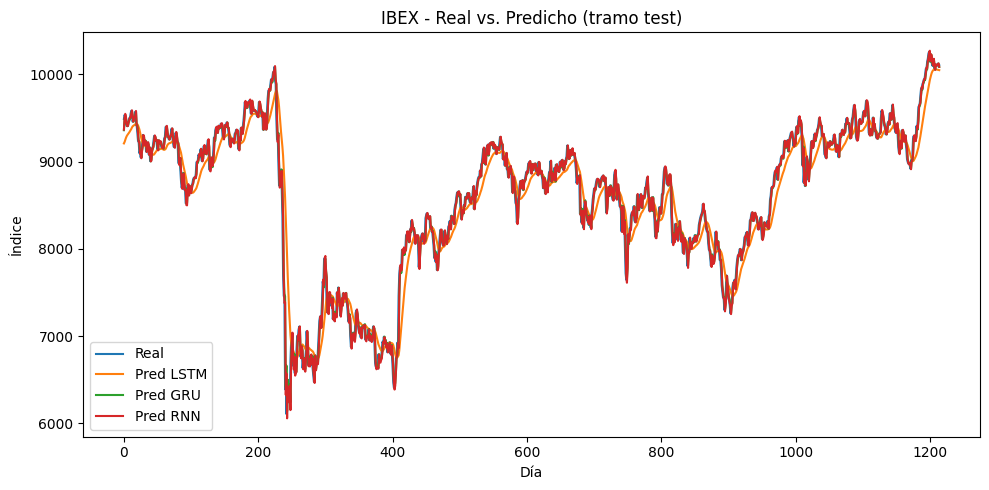

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test_real, label="Real")
plt.plot(pred_lstm_real, label="Pred LSTM")
plt.plot(pred_gru_real, label="Pred GRU")
plt.plot(pred_rnn_real, label="Pred RNN")
plt.title("IBEX - Real vs. Predicho (tramo test)")
plt.xlabel("Día")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def predecir_siguiente(model, df_original, scaler, col_target="Price", window_size=30):
    # usamos el df limpio que tenías: ibex_df
    ultimos = df_original[[col_target]].values.astype(float)[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)
    X_input = ultimos_scaled.reshape((1, window_size, 1))
    pred_scaled = model.predict(X_input)
    pred = scaler.inverse_transform(pred_scaled)
    return pred[0,0]

pred_manana_lstm = predecir_siguiente(lstm_model, ibex_df, scaler_ibex, col_target="Price", window_size=window_size)
print("Predicción IBEX próximo día (LSTM):", pred_manana_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicción IBEX próximo día (LSTM): 10044.421
